In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import matplotlib.pyplot as plt
import numpy as np
import time
import theano
import theano.tensor as T
from IPython import display
import pickle
from utils import one_hot
import utils
from utils import angle2sincos, sincos2angle
from model import Model
import itertools

In [2]:
def show(x, split=True, clear=False, figsize=None):
    if clear:
        display.clear_output(wait=True)
        display.display()
    def f(x):
        if figsize is not None:
            plt.figure(figsize=figsize)
        if not split:
            plt.imshow(x)
            plt.axis('off')
            plt.show()
        else:
            plt.imshow(np.concatenate((x[...,:3], x[...,3:].repeat(3, axis=-1)), axis=1))
            plt.axis('off')
            plt.show()
    if len(x.shape) == 3:
        f(x)
    else:
        for i in x:
            f(i)
            
def create_grid(frames, rows, **kw):
    img = []
    assert len(frames) % rows == 0
    cols = len(frames) // rows
    for i in range(0, len(frames), cols):
        img.append(frames[i:i+cols])
    img = [np.concatenate(i, axis=1) for i in img]
    img = np.concatenate(img, axis=0)
    return img

def interpolate(z1, z2, n=16):
    frames = []
    for i in range(n):
        z = (z1 + (z2-z1) * i / (n-1))
        frames.append(model.gen({'z': z})[0])
    return frames

In [3]:
angles1 = np.array([20.0, 30.0])
angles2 = np.array([-175.0, -163.0, -151.0, -140.0, -128.0, -117.0, -105.0, -93.0, -82.0, -70.0, -59.0, -47.0, -35.0, -24.0, -12.0, 0.0, 11.0, 23.0, 34.0, 46.0, 58.0, 69.0, 81.0, 92.0, 104.0, 116.0, 127.0, 139.0, 150.0, 162.0, 174.0])
angles = angle2sincos([(i, j) for i in angles1 for j in angles2])
DEFAULT_T = np.float32([0,0,0,1,1,0,1,1])

In [26]:
model = Model(reg=True)
model.load('data/model.pkl')

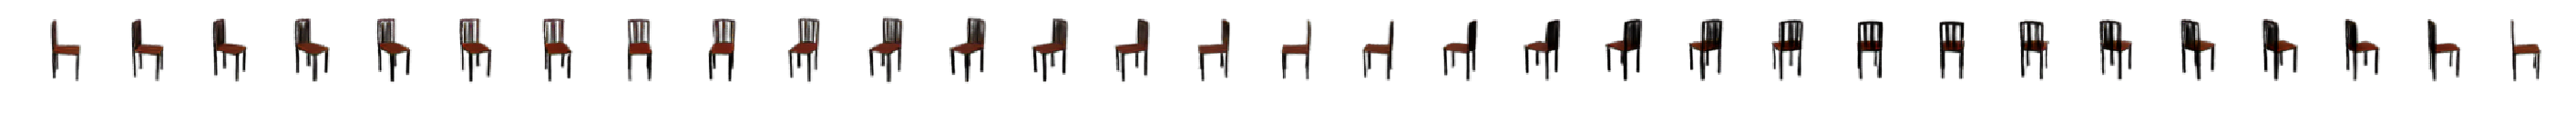

In [27]:
gen_frames = model.gen([7] * 31, angles[:31], DEFAULT_T[np.newaxis].repeat(31, axis=0))
show(create_grid(list(gen_frames), 1), split=False, figsize=(50,50))

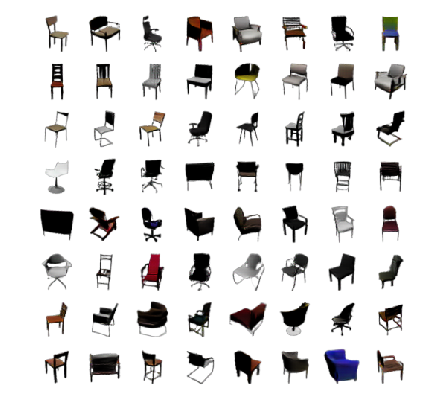

In [29]:
np.random.seed(3439)
classes = np.random.randint(0, 843, 64)
angs = angles[sorted(np.random.choice(range(62), 64))]
imgs = model.gen(classes, angs, DEFAULT_T[np.newaxis].repeat(64, 0))
show(create_grid(imgs, 8), split=False, figsize=(7,7))

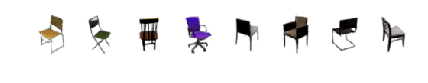

In [30]:
samples = [(58,  np.float32([ 0.5,         0.86602539, -0.57357645,  0.81915206])),
               (239, np.float32([ 0.5,         0.86602539, -0.48480961, -0.87461972])),
               (156, np.float32([ 0.5,         0.86602539,  0.98768836,  0.15643446])),
               (166, np.float32([ 0.34202015,  0.93969262, -0.64278764, -0.76604444])),
               (200, np.float32([ 0.5,         0.86602539,  0.89879405, -0.43837115])),
               (620, np.float32([ 0.34202015,  0.93969262, -0.7313537,   0.68199837])),
               (453, np.float32([ 0.34202015,  0.93969262,  0.84804809,  0.52991927])),
               (836, np.float32([ 0.5,         0.86602539,  0.5,        -0.86602539]))]
imgs = []
real_imgs = []
for (c,v) in samples:
    img = model.gen([c]*2, v[np.newaxis].repeat(2, axis=0), DEFAULT_T[np.newaxis].repeat(2, axis=0))
    imgs.append(img[0])
img = np.concatenate(imgs, axis=1)
show(img, split=False, figsize=(7,7))

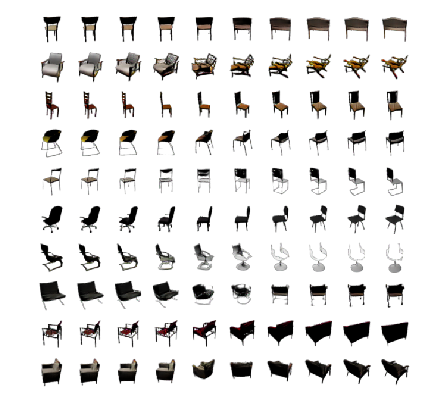

In [31]:
np.random.seed(3439)
arr = []
width = 10
for _ in range(10):
    c1, c2 = tuple(np.random.randint(0, 843, 2))
    a1, a2 = tuple(angles[sorted(np.random.choice(range(62), 2))])
    imgs = model.gen(np.float32(one_hot([c1] * width, 843) * (1-np.arange(width)[:, np.newaxis]/(width-1)) +\
                         one_hot([c2] * width, 843) * np.arange(width)[:, np.newaxis]/(width-1)), 
                     np.float32([i/(width-1) * a2 + (1-i/(width-1)) * a1 for i in range(width)]), 
                     DEFAULT_T[np.newaxis].repeat(width, 0))
    arr.append(create_grid(imgs, 1))
show(create_grid(arr, 10), split=False, figsize=(7,7))